In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, median_absolute_error

# Deep Learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [33]:
data = pd.read_csv('Dataset/Training/Features_Variant_1.csv')
column_names_updated = [
    "Page_Popularity_Likes", "Page_Checkins", "Page_Talking_About", "Page_Category",
    "Derived_1", "Derived_2", "Derived_3", "Derived_4", "Derived_5",
    "Derived_6", "Derived_7", "Derived_8", "Derived_9", "Derived_10",
    "Derived_11", "Derived_12", "Derived_13", "Derived_14", "Derived_15",
    "Derived_16", "Derived_17", "Derived_18", "Derived_19", "Derived_20",
    "Derived_21", "Derived_22", "Derived_23", "Derived_24", "Derived_25",
    "CC1_Total_Comments", "CC2_Comments_Last_24h", "CC3_Comments_48_to_24h",
    "CC4_Comments_First_24h", "CC5_CC2_CC3_Difference", "Base_Time",
    "Post_Length", "Post_Share_Count", "Post_Promotion_Status", "H_Local",
    "Published_Sunday", "Published_Monday", "Published_Tuesday",
    "Published_Wednesday", "Published_Thursday", "Published_Friday",
    "Published_Saturday", "BaseDate_Sunday", "BaseDate_Monday",
    "BaseDate_Tuesday", "BaseDate_Wednesday", "BaseDate_Thursday",
    "BaseDate_Friday", "BaseDate_Saturday", "Target_Comment_Volume"
]
data.columns = column_names_updated
display(data.describe())

,Page_Popularity_Likes,Page_Checkins,Page_Talking_About,Page_Category,Derived_1,Derived_2,Derived_3,Derived_4,Derived_5,Derived_6,...,Published_Friday,Published_Saturday,BaseDate_Sunday,BaseDate_Monday,BaseDate_Tuesday,BaseDate_Wednesday,BaseDate_Thursday,BaseDate_Friday,BaseDate_Saturday,Target_Comment_Volume
count,4.094800e+04,40948.000000,4.094800e+04,40948.000000,40948.000000,40948.000000,40948.000000,40948.000000,40948.000000,40948.000000,...,40948.000000,40948.000000,40948.000000,40948.000000,40948.000000,40948.000000,40948.000000,40948.000000,40948.000000,40948.000000
mean,1.313830e+06,4676.247949,4.480133e+04,24.255348,1.586280,443.324998,55.721469,35.646381,67.464077,0.219473,...,0.146161,0.136930,0.141643,0.132510,0.137638,0.148603,0.150850,0.143890,0.144867,7.323068
std,6.785834e+06,20593.423357,1.109349e+05,19.950496,20.753426,496.698029,86.934332,69.960877,81.569243,10.055268,...,0.353272,0.343777,0.348688,0.339048,0.344524,0.355701,0.357907,0.350982,0.351971,35.494965
min,3.600000e+01,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.673400e+04,0.000000,6.980000e+02,9.000000,0.000000,45.000000,5.527273,2.000000,8.278756,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.929110e+05,0.000000,7.141000e+03,18.000000,0.000000,241.000000,23.374101,12.000000,35.069140,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.204214e+06,99.000000,5.026400e+04,32.000000,0.000000,717.000000,71.828829,42.000000,102.554954,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,4.869723e+08,186370.000000,6.089942e+06,106.000000,2341.000000,2341.000000,2341.000000,2341.000000,731.394558,1923.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1305.000000


In [34]:
# see feature engineering notebook for explanation of proposal 1
published_day_mapping = {
    "Published_Sunday": "Sunday",
    "Published_Monday": "Monday",
    "Published_Tuesday": "Tuesday",
    "Published_Wednesday": "Wednesday",
    "Published_Thursday": "Thursday",
    "Published_Friday": "Friday",
    "Published_Saturday": "Saturday"
}

basedate_day_mapping = {
    "BaseDate_Sunday": "Sunday",
    "BaseDate_Monday": "Monday",
    "BaseDate_Tuesday": "Tuesday",
    "BaseDate_Wednesday": "Wednesday",
    "BaseDate_Thursday": "Thursday",
    "BaseDate_Friday": "Friday",
    "BaseDate_Saturday": "Saturday"
}

data['Published_Day'] = data[[*published_day_mapping.keys()]].idxmax(axis=1).map(published_day_mapping)
data['BaseDate_Day'] = data[[*basedate_day_mapping.keys()]].idxmax(axis=1).map(basedate_day_mapping)
data.drop(columns=list(published_day_mapping.keys()) + list(basedate_day_mapping.keys()), inplace=True)

# Drop Post Promotion Status always 0
data = data.drop("Post_Promotion_Status", axis=1)

# Drop CC1 since it's highly correlated with CC4 also remove its derived features
data = data.drop("CC1_Total_Comments", axis=1)
data = data.drop("Derived_1", axis=1)
data = data.drop("Derived_2", axis=1)
data = data.drop("Derived_3", axis=1)
data = data.drop("Derived_4", axis=1)
data = data.drop("Derived_5", axis=1)

# We think that min, max and median CCs values are unnecessary
data = data.drop("Derived_6", axis=1)
data = data.drop("Derived_7", axis=1)
data = data.drop("Derived_9", axis=1)
data = data.drop("Derived_11", axis=1)
data = data.drop("Derived_12", axis=1)
data = data.drop("Derived_14", axis=1)
data = data.drop("Derived_16", axis=1)
data = data.drop("Derived_17", axis=1)
data = data.drop("Derived_19", axis=1)
data = data.drop("Derived_21", axis=1)
data = data.drop("Derived_22", axis=1)
data = data.drop("Derived_24", axis=1)

# I think cyclic encoding is more efficient way than one-hot encoding
def encode_day(day_name):
    day_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
        'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }
    day_idx = day_map.get(day_name, None)
    return (
        np.sin(2 * np.pi * day_idx / 7),
        np.cos(2 * np.pi * day_idx / 7)
    )

for col in ['Published_Day', 'BaseDate_Day']:
    data[[f"{col}_Sin", f"{col}_Cos"]] = pd.DataFrame(
        data[col].apply(encode_day).tolist(),
        index=data.index
    )

data.drop(['Published_Day', 'BaseDate_Day'], axis=1, inplace=True)

# Post Length can be treated as a categorical feature and use value encoding
bins = [0, 10, 50, 100, 200, 500, 1000, 5000, np.inf]
labels = [
    '0-10 (micro)',
    '11-50 (short)',
    '51-100 (medium)',
    '101-200 (long)',
    '201-500 (essay)',
    '501-1000 (article)',
    '1001-5000 (long_doc)',
    '5000+ (extreme)'
]

data['Post_Length_Category'] = pd.cut(
    data['Post_Length'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

ordinal_mapping = {
    '0-10 (micro)': 1,
    '11-50 (short)': 2,
    '51-100 (medium)': 3,
    '101-200 (long)': 4,
    '201-500 (essay)': 5,
    '501-1000 (article)': 6,
    '1001-5000 (long_doc)': 7,
    '5000+ (extreme)': 8
}
data['Post_Length_Encoded'] = data['Post_Length_Category'].map(ordinal_mapping).astype('int64')

data = data.drop("Post_Length_Category", axis=1)
data = data.drop("Post_Length", axis=1)

# This column calculates the average number of comments per hour in the last 24 hours before the Base Time
data['Average_Comment_Last24h'] = (
    data['CC2_Comments_Last_24h'] /
    np.maximum(np.minimum(data['Base_Time'], 24), 1)
)

# The percent_change column quantifies the percentage growth or decline in engagement between two time windows, depending on the post's age (Base_Time)
data['CC3_safe'] = np.maximum(data['CC3_Comments_48_to_24h'], 1)
data['CC4_safe'] = np.maximum(data['CC4_Comments_First_24h'], 1)

data['engagement_ratio'] = np.where(
    data['Base_Time'] >= 48,
    np.log1p(data['CC2_Comments_Last_24h']) - np.log1p(data['CC3_safe']),  # log(CC2/CC3)
    np.where(
        data['Base_Time'] >= 24,
        np.log1p(data['CC2_Comments_Last_24h']) - np.log1p(data['CC4_safe']),  # log(CC2/CC4)
        0
    )
)
data['percent_change'] = np.expm1(data['engagement_ratio']) * 100

data = data.drop("CC3_safe", axis=1)
data = data.drop("CC4_safe", axis=1)
data = data.drop("engagement_ratio", axis=1)

# I think after these 2 columns we don't need CC5, these columns created are alternative to CC5
data = data.drop("CC5_CC2_CC3_Difference", axis=1)

target_col = data.pop('Target_Comment_Volume')
data['Target_Comment_Volume'] = target_col

## EXPERIMENTS
#### 1. Removing of outliers
results of test: (Train R² / Test R² / MSE / RMSE)

a) no outlier removal: model fits well, but affected by large outliers (0.56, 0.53, 467.04, 21.61)

b) remove x and y outliers: low error, but model trained on less data (0.32, 0.34, 1.72, 1.31) 

c) clip only the target value: balanced — outliers controlled, full dataset used (0.49, 0.48, 3.91, 1.98)
##### Conclusion: Clipping only the target value when removing outliers performed the best but not as well as other methods, removed to be able to compare metrics between models 

#### 2. Log transform target value
##### Conclusion: This resulted in very poor results and a negative r^2 value and so we opted to not log tranform the y-values 

#### 3. Apply L2 (Ridge) regularization
LIN REGRESSION:

Cross-Validation R² scores: [0.52861575 0.64822492 0.53559273 0.59577063 0.44102323]

Average R²: 0.5498454526343786

Mean Squared Error: 479.11

RMSE: 21.89

Mean Absolute Error: 6.48

R² Score: 0.52

RIDGE:

Cross-Validation R² scores: [0.5286789  0.64818756 0.53563138 0.59574145 0.44099878]

Average R²: 0.5498476139621546

Mean Squared Error: 479.09

RMSE: 21.89

Mean Absolute Error: 6.48

R² Score: 0.52

##### Conclusion: This resulted in similar results to linear regression and we added a flag to compare results within the same notebook

#### 4. Cross-validation
##### Conclusion: This resulted in similar results through iterations as shown above

#### 5. Apply PCA

LinReg Regression with PCA Results

Train R²: 0.5484

Test R²: 0.5165

Ridge Regression with PCA Results

Train R²: 0.5484

Test R²: 0.5165

##### Conclusion: Performance was almost the same with and without PCA but we were able to visualize and learn the optimal number of components and keep PCA

#### 6. From our learnings in DataPreprocessing.ipynb, apply an autoencoder with encoder dimension = 32, hidden layer size = 128
##### Conclusion: Performed the best, results shown below:
<----Linear Regression after autoencoder---->
Root mean Squared Error: 21.0687

Mean absolute Error: 5.4965

Mean Squared Error: 443.89

Median absolute Error: 2.1101

R² Score: 0.5408

In [35]:
# move the target column to the end of the dataframe
target_col = data.pop('Target_Comment_Volume')
data['Target_Comment_Volume'] = target_col

# separate features and target
X = data.iloc[:, :-1]  # features
y = data.iloc[:, -1]  # target

# Experiment 1: we clip only the target value when removing outliers
# Q1 = y.quantile(0.25)
# Q3 = y.quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# non_outliers = (y >= lower_bound) & (y <= upper_bound)
# y = np.clip(y, lower_bound, upper_bound)

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # scale before splitting train-test so that all values are in the same range

In [36]:
# ONLY RUN WHEN TESTING AUTOENCODER
def test(model, X_test, y_test, y_pred=None):
    '''
    We test our model and print various metrics for comparison

    Params:
    model: to test
    X_test: which are features to test
    y_test: the real values that match X_test
    '''
    if y_pred is None:
        y_pred = model.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mabse = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Root mean Squared Error: {rmse:.4f}")
    print(f"Mean absolute Error: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Median absolute Error: {mabse:.4f}")
    print(f"R² Score: {r2:.4f}")

In [37]:
# ONLY RUN WHEN TESTING AUTOENCODER
# Define autoencoder architecture
input_dim = X_scaled.shape[1]
encoding_dim = 32 # Dimension of the encoded representation

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)

# Encode features
X_encoded = encoder.predict(X_scaled)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_enc, y_train_enc)
print("<----Linear Regression after autoencoder---->")
test(lr, X_test_enc, y_test_enc)

1280/1280 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
<----Linear Regression after autoencoder---->
Root mean Squared Error: 21.0596
Mean absolute Error: 5.9361
Mean Squared Error: 443.51
Median absolute Error: 2.5433
R² Score: 0.5412


In [38]:
model_train_flag = "Ridge" # either LinReg or Ridge

In [39]:
# PCA
pca = PCA(n_components=0.95)  # retain 95% variances

if model_train_flag == "LinReg":
    pipeline = Pipeline([
        ('pca', pca),
        ('reg', LinearRegression())
    ])
elif model_train_flag == "Ridge":
    pipeline = Pipeline([
        ('pca', pca),
        ('reg', Ridge(alpha=10))
    ])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)  # setting random_state allows for the same split on each run

In [41]:
# fit pipeline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [42]:
# evaluation
print(f"{model_train_flag} Regression with PCA Results")
print(f"Train R²: {pipeline.score(X_train, y_train):.4f}")
print(f"Test R²: {pipeline.score(X_test, y_test):.4f}")

Ridge Regression with PCA Results
Train R²: 0.5484
Test R²: 0.5165


In [43]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_scaled, y, scoring='r2', cv=cv)
print("Cross-Validation R² scores:", cv_scores)
print("Average R²:", np.mean(cv_scores))

mse = mean_squared_error(y_test, y_pred)  # lec 4, slide 20
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Cross-Validation R² scores: [0.5286789  0.64818756 0.53563138 0.59574145 0.44099878]
Average R²: 0.5498476139621546
Mean Squared Error: 479.09
RMSE: 21.89
Mean Absolute Error: 6.48
R² Score: 0.52


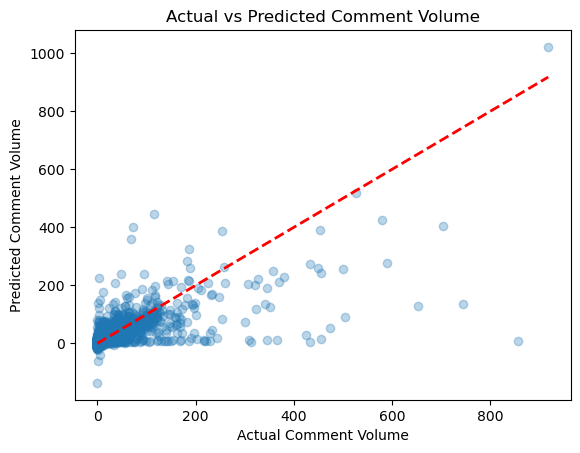

In [44]:
# best = points close to the diagonal
plt.scatter(y_test, y_pred, alpha=0.3)  # alpha=0.3 for semi-transparent dots
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # red diagonal line
plt.xlabel("Actual Comment Volume")
plt.ylabel("Predicted Comment Volume")
plt.title("Actual vs Predicted Comment Volume")
plt.show()


### Summary
Linear regression proves as a good baseline model and we ran multiple experiments to play around with what would give us the best result.